# 4. Semantic Space Construction

In this NB, I will apply the new `heads` edge feature to extract head nouns from their phrase and record their co-occurring verbs, subjects, objects, and coordinates. Each of these relationships is assigned a weight. Those co-occurrences are then placed into a matrix. Then I assign an associational measure to the counts

In [57]:
import collections, os, math
# put clustering function in path
if __name__ == '__main__' and __package__ is None:
    os.sys.path.append('../kmedoids')
import numpy as np
import pandas as pd
import kmedoids
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from tf.fabric import Fabric
from scipy.cluster.hierarchy import linkage, dendrogram


TF = Fabric(locations='~/github', modules=['etcbc/bhsa/tf/c', 'semantics/tf/c'])
api = TF.load('''
                book chapter verse
                function lex vs language
                pdp freq_lex gloss domain
                voc_lex_utf8
                heads
              ''')
api.makeAvailableIn(globals())

This is Text-Fabric 3.2.5
Api reference : https://github.com/Dans-labs/text-fabric/wiki/Api
Tutorial      : https://github.com/Dans-labs/text-fabric/blob/master/docs/tutorial.ipynb
Example data  : https://github.com/Dans-labs/text-fabric-data

116 features found and 0 ignored
  0.00s loading features ...
   |     0.01s B book                 from /Users/cody/github/etcbc/bhsa/tf/c
   |     0.01s B chapter              from /Users/cody/github/etcbc/bhsa/tf/c
   |     0.00s B verse                from /Users/cody/github/etcbc/bhsa/tf/c
   |     0.07s B function             from /Users/cody/github/etcbc/bhsa/tf/c
   |     0.13s B lex                  from /Users/cody/github/etcbc/bhsa/tf/c
   |     0.12s B vs                   from /Users/cody/github/etcbc/bhsa/tf/c
   |     0.14s B language             from /Users/cody/github/etcbc/bhsa/tf/c
   |     0.12s B pdp                  from /Users/cody/github/etcbc/bhsa/tf/c
   |     0.09s B freq_lex             from /Users/cody/github/etcbc/bh

## Gather and Count Noun Relations

Now I will gather nouns from the Hebrew Bible and count syntactic co-occurrences.

In [2]:
# configure weights
path_weights = {'Subj': {'Pred': 1,
                         #'Objc': 1
                        },
                'Objc': {
                         'Pred': 1,
                         #'Subj': 1
                        },
                'coor': 1
               }

In [3]:
cooccurrences = collections.defaultdict(lambda: collections.Counter()) # noun counts here

# Subj/Objc Counts
for phrase in F.otype.s('phrase'):
    
    # skip non-Hebrew sections
    language = F.language.v(L.d(phrase, 'word')[0]) 
    if language != 'Hebrew':
        continue
    
    # skip non subject/object phrases
    function = F.function.v(phrase)
    if function not in {'Subj', 'Objc'}:
        continue
    
    # get head nouns
    nouns = set(F.lex.v(w) for w in E.heads.f(phrase)) # count lexemes only once
    if not nouns:
        continue
    
    # restrict on frequency
    freq = [F.freq_lex.v(L.u(w, 'lex')[0]) for w in E.heads.f(phrase)]
    if min(freq) < 10:
        continue

    # restrict on proper names
    types = set(F.pdp.v(w) for w in E.heads.f(phrase))
    if {'nmpr'} & types:
        continue

    # restrict on domain
    if F.domain.v(L.u(phrase, 'clause')[0]) != 'N':
        continue
    
    # gather contextual data
    clause = L.u(phrase, 'clause')[0]
    good_paths = path_weights[function]
    paths = [phrase for phrase in L.d(clause, 'phrase')
                if F.function.v(phrase) in good_paths.keys()
            ]
    
    # make the counts
    for path in paths:
        
        pfunct = F.function.v(path)
        weight = good_paths[pfunct]
        
        # count for verb
        if pfunct == 'Pred':
            verb = [w for w in L.d(path, 'word') if F.pdp.v(w) == 'verb'][0]
            verb_lex = F.lex.v(verb)
            verb_stem = F.vs.v(verb)
            verb_basis = function + '.' + verb_lex + '.' + verb_stem # with function name added
            if verb and F.lex.v(verb) not in {'HJH['}: # omit "to be" verbs, others?
                for noun in nouns:
                    cooccurrences[noun][verb_basis] += 1
        
        # count for subj/obj
        else:
            conouns = E.heads.f(path)
            cnoun_bases = set(function + '.' + F.lex.v(w) + f'.{pfunct}' for w in conouns) # with function name added
            counts = dict((basis, weight) for basis in cnoun_bases)
            if counts:
                for noun in nouns:
                    cooccurrences[noun].update(counts)
    
    # count coordinates
    for noun in nouns:
        for cnoun in nouns:
            if cnoun != noun:
                cnoun_basis = 'coor.'+cnoun # with coordinate function name
                cooccurrences[noun][cnoun_basis] += path_weights['coor']
                
# weed out results with little data
cooccurrences = dict((word, counts) for word, counts in cooccurrences.items()
                        if sum(counts.values()) >= 10
                    )
                
cooccurrences = pd.DataFrame(cooccurrences).fillna(0)
cooccurrences = cooccurrences

print(len(cooccurrences.columns), 'nouns')
print(len(cooccurrences.index), 'cooccurrences')

189 nouns
1133 cooccurrences


## Apply Association Measure

In [4]:
def safe_log(number):
    '''
    Evaluate for zero before applying log function.
    '''
    if number == 0:
        return 0
    else:
        return math.log(number)
    
def loglikelihood(k, l, m, n, log):
    '''
    Returns the log-likelihood when the supplied elements are given.
    '''
    
    p1 = (k*log(k)) + (l*log(l)) + (m*log(m)) + (n*log(n))        
    p2 = ((k+l)*log(k+l)) - ((k+m)*log(k+m))
    p3 = ((l+n)*log(l+n)) - ((m+n)*log(m+n))
    p4 = ((k+l+m+n))*log(k+l+m+n)
    llikelihood = 2*(p1-p2-p3+p4)
    return llikelihood

def apply_loglikelihood(comatrix):
    
    '''
    Adjusts values in a cooccurrence matrix using log-likelihood. 
    Requires a cooccurrence matrix.
    '''
    new_matrix = comatrix.copy()
    i = 0 
    indent(reset=True)
    info('beginning calculations...')
    indent(1, reset=True)
    for target in comatrix.columns:
        for basis in comatrix.index:
            k = comatrix[target][basis]
            
            if not k:
                i += 1
                if i % 500000 == 0:
                    indent(1)
                    info(f'at iteration {i}')
                continue
            
            l = comatrix.loc[basis].sum() - k
            m = comatrix[target].sum() - k
            n = comatrix.values.sum() - (k+l+m)
            ll = loglikelihood(k, l, m, n, safe_log)
            new_matrix[target][basis] = ll

            i += 1
            if i % 500000 == 0:
                indent(1)
                info(f'at iteration {i}')
    indent(0)
    info(f'FINISHED at iteration {i}')
    return new_matrix

In [5]:
test_ll = apply_loglikelihood(cooccurrences) / 10000 # division to make numbers more managable
os.system('say "The log likelihood is ready!"')

  0.00s beginning calculations...
  3.90s FINISHED at iteration 214137


0

In [6]:
cooccurrences.head(25)

,<BD/,<BDH/,<DH/,<DWT/,<JN/,<JR/,<LH/,<M/,<MWD/,<NN/,...,XV>T/,XWMH/,XYJ/,XYR/,Y>N/,YDQH/,ZBX/,ZHB/,ZQN/,ZR</
Objc.<BD[.hif,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Objc.<BD[.qal,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Objc.<BR[.hif,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Objc.<BR[.qal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Objc.<DH[.qal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
Objc.<FH[.qal,0.0,1.0,0.0,0.0,0.0,1.0,4.0,0.0,4.0,0.0,...,1.0,0.0,0.0,1.0,0.0,4.0,1.0,8.0,0.0,0.0
Objc.<LH[.hif,0.0,0.0,0.0,0.0,0.0,0.0,33.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Objc.<MD[.hif,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Objc.<MD[.qal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Objc.<NC[.qal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## PMI
Pointwise Mutual Information Scores

In [7]:
def apply_pmi(col):
    
    '''
    Apply PMI to a given column.
    '''
    
    expected = col * cooccurrences.sum(axis=1) / cooccurrences.values.sum()
    pmi = np.log(col / expected).fillna(0)
    
    return pmi

test_pmi = cooccurrences.apply(lambda k: apply_pmi(k))
os.system('say "The PMI is ready!"')

0

## Data Exploration

In [8]:
def get_lex(lex_string):
    '''
    Return ETCBC lex node number from a lexeme string.
    '''
    lex = next(lex for lex in F.otype.s('lex') if F.lex.v(lex) == lex_string)
    
    return lex

pca = PCA(n_components=2)

## Adjusted Frequencies

Visualize the total observations for each word.

### Raw Frequencies

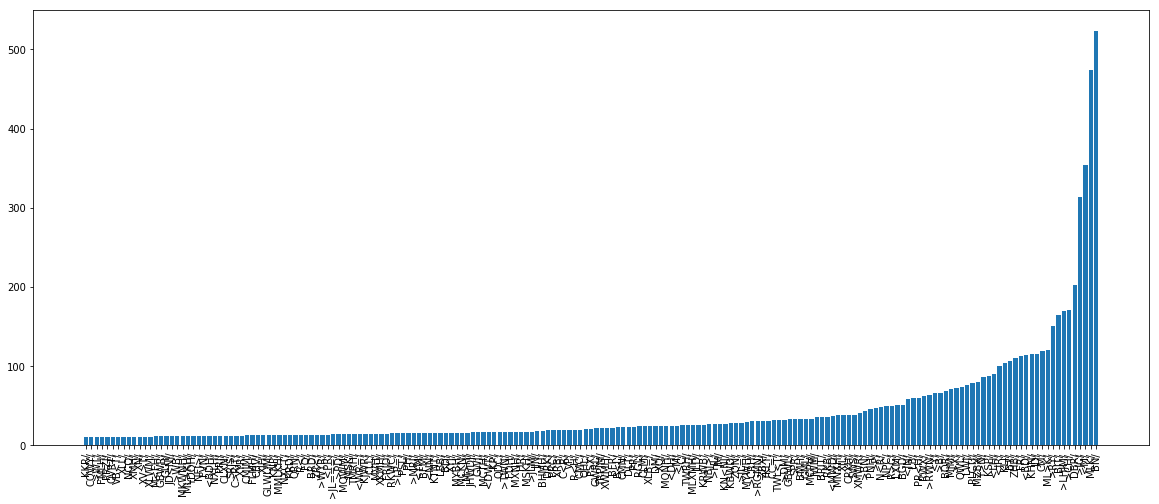

In [9]:
plt.figure(figsize=(20, 8))
plt.bar(cooccurrences.sum().sort_values().index, cooccurrences.sum().sort_values().values)
plt.xticks(rotation='vertical')
plt.show()

### Log Likelihood Adjusted Frequencies

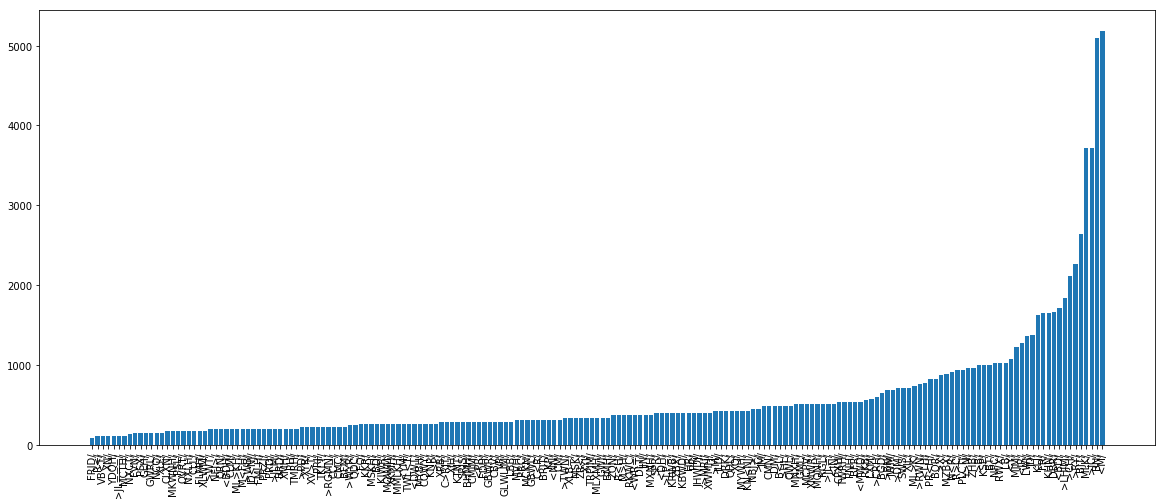

In [10]:
plt.figure(figsize=(20, 8))
plt.bar(test_ll.sum().sort_values().index, test_ll.sum().sort_values().values)
plt.xticks(rotation='vertical')
plt.show()

### PMI Adjusted Frequencies

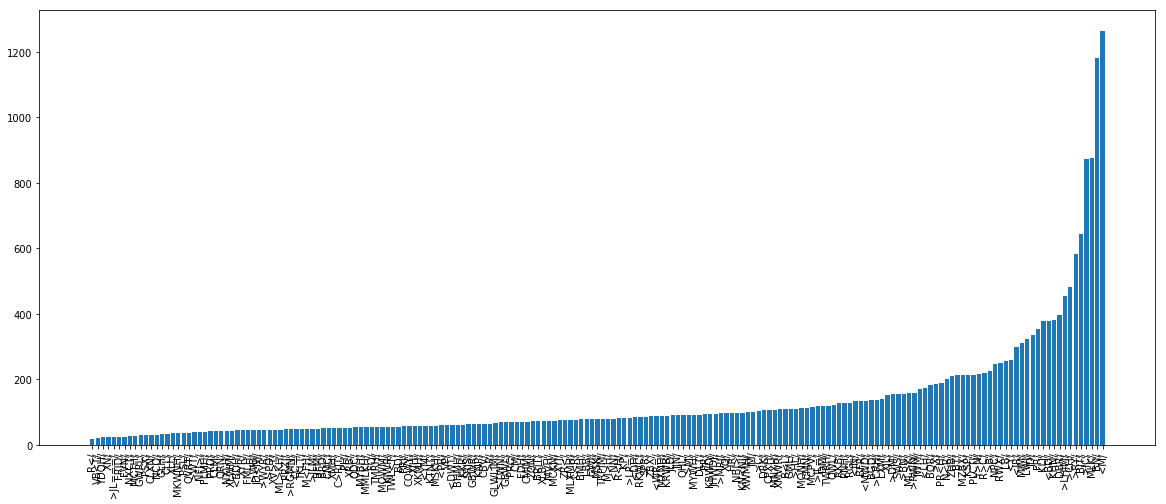

In [11]:
plt.figure(figsize=(20, 8))
plt.bar(test_pmi.sum().sort_values().index, test_pmi.sum().sort_values().values)
plt.xticks(rotation='vertical')
plt.show()

### Top Counts

**Top Raw Counts**

In [12]:
cooccurrences.sum().sort_values(ascending=False).head(25)

BN/       524.0
MLK/      474.0
<M/       354.0
>JC/      313.0
DBR/      202.0
>CH/      170.0
>LHJM/    169.0
BJT/      164.0
>RY/      150.0
ML>K/     120.0
CM/       118.0
JD/       115.0
KHN/      115.0
<BD/      114.0
FR/       112.0
ZHB/      110.0
BT/       106.0
KLJ/      103.0
<JR/       99.0
<LH/       90.0
KSP/       87.0
Y>N/       86.0
MZBX/      79.0
PLCTJ/     78.0
LWJ/       75.0
dtype: float64

**Top Log-likelihood**

In [13]:
test_ll.sum().sort_values(ascending=False).head(25)

<M/       5189.214005
BN/       5095.536399
>JC/      3714.604834
MLK/      3713.693048
BJT/      2635.885174
>RY/      2259.249399
>CH/      2117.931610
>LHJM/    1832.335244
<BD/      1707.965462
DBR/      1666.492738
KHN/      1652.443903
FR/       1648.878924
KLJ/      1622.859756
JD/       1369.437655
LWJ/      1363.036855
<JR/      1279.973216
MJM/      1222.916628
<Y/       1077.011830
LB/       1022.952880
RWX/      1022.407354
NPC/      1021.178799
BT/        994.409591
KSP/       993.052452
>B/        992.877485
ZHB/       966.867374
dtype: float64

**Top PMI counts**

In [14]:
test_pmi.sum().sort_values(ascending=False).head(25)

<M/       1265.320828
BN/       1182.665762
MLK/       874.756998
>JC/       873.858640
BJT/       643.651064
>RY/       583.619940
>CH/       483.004380
>LHJM/     453.242327
DBR/       396.757822
KHN/       381.630634
<BD/       378.900696
KLJ/       377.217472
FR/        353.854464
JD/        335.564051
LWJ/       323.207908
MJM/       309.606550
<JR/       298.922136
<Y/        259.479935
LB/        257.082438
RWX/       250.856750
NPC/       247.710148
>B/        224.702565
R>C/       220.278509
Y>N/       216.628634
PLCTJ/     213.920311
dtype: float64

## Vector Space Construction

### Raw Count Vector Space

Semantic Space with Raw Counts

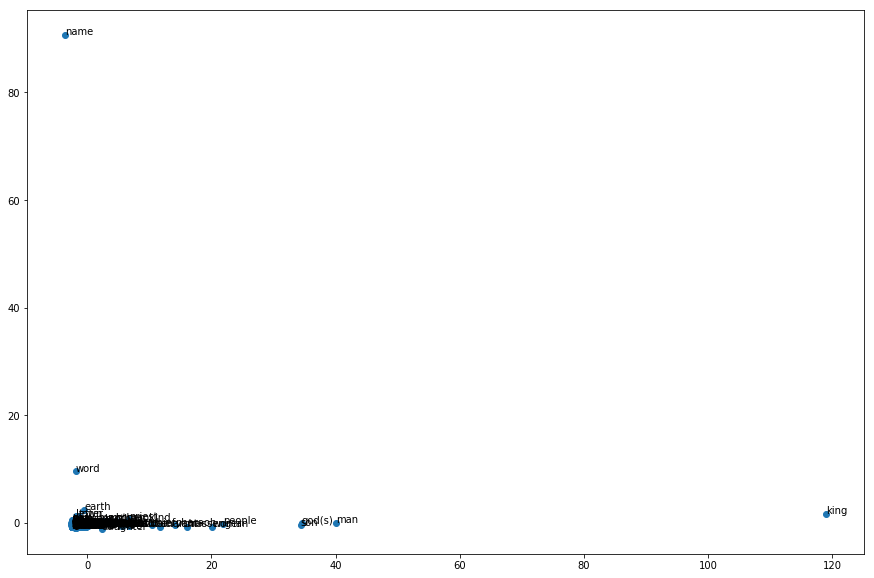

In [125]:
pca_raw = pca.fit_transform(cooccurrences.T.values)

# create a scatter plot of the projection
plt.figure(1, figsize=(15, 10))
plt.scatter(pca_raw[:, 0], pca_raw[:, 1])

zoom = [-5, 25, -5, 5]
zoom1 = [-2.5, 5, -1, .8]
zoom2 = [-2.5, -1.3, -0.9, -0.25]
#plt.axis(zoom)

# annotate 
words = [F.gloss.v(get_lex(l)) for l in cooccurrences.columns]
for i, word in enumerate(words):
    plt.annotate(word, xy=(pca_raw[i, 0], pca_raw[i, 1]))

### Log-likelihood Vector Space

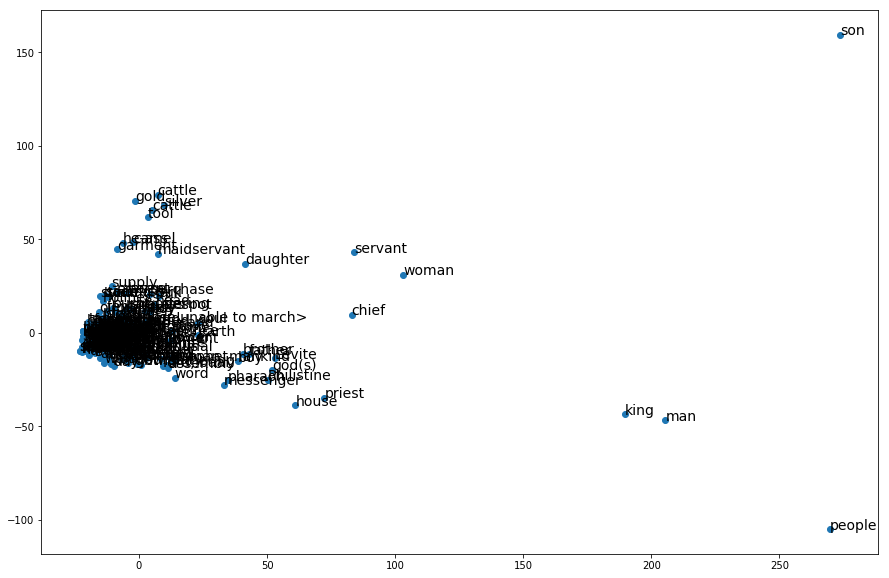

In [126]:
pca_ll = pca.fit_transform(test_ll.T.values)

# create a scatter plot of the projection
plt.figure(1, figsize=(15, 10))
plt.scatter(pca_ll[:, 0], pca_ll[:, 1])

#plt.axis([-0.2, 0.5, -0.5, 0.5])

# annotate 
words = [F.gloss.v(get_lex(l)) for l in test_ll.columns]
for i, word in enumerate(words):
    plt.annotate(word, xy=(pca_ll[i, 0], pca_ll[i, 1]), fontsize=14)
    
plt.savefig('images/ll_space.png')

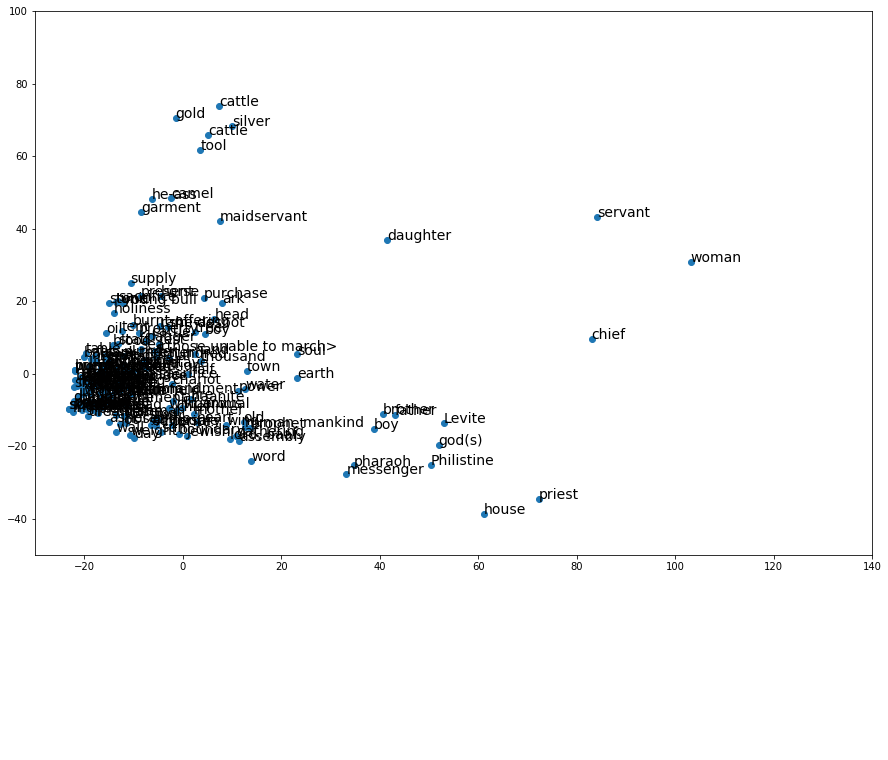

In [127]:
# closer view of LL

# create a scatter plot of the projection
plt.figure(1, figsize=(15, 10))
plt.scatter(pca_ll[:, 0], pca_ll[:, 1])

plt.axis([-30, 140, -50, 100])

# annotate 
words = [F.gloss.v(get_lex(l)) for l in test_ll.columns]
for i, word in enumerate(words):
    plt.annotate(word, xy=(pca_ll[i, 0], pca_ll[i, 1]), fontsize=14)
    
plt.savefig('images/ll_space_zoom.png')

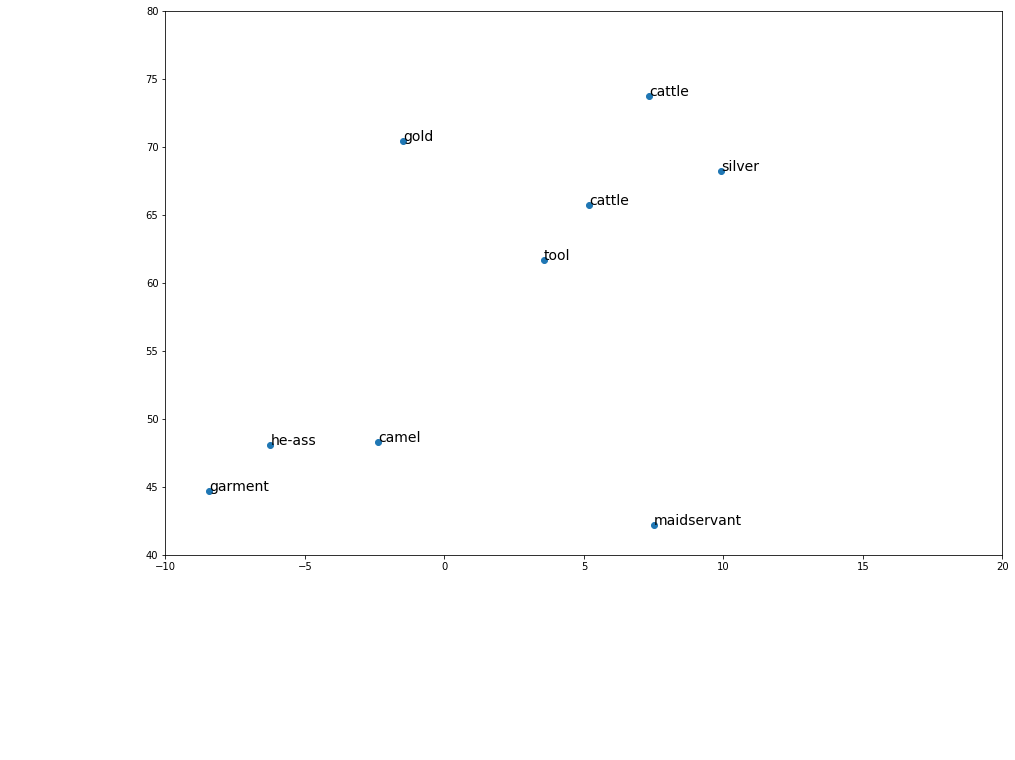

In [128]:
# closer view of possessions cluster

# create a scatter plot of the projection
plt.figure(1, figsize=(15, 10))
plt.scatter(pca_ll[:, 0], pca_ll[:, 1])

plt.axis([-10, 20, 40, 80])

# annotate 
words = [F.gloss.v(get_lex(l)) for l in test_ll.columns]
for i, word in enumerate(words):
    plt.annotate(word, xy=(pca_ll[i, 0], pca_ll[i, 1]), fontsize=14)
    
plt.savefig('images/ll_space_possessions.png')

### Pointwise Mutual Information

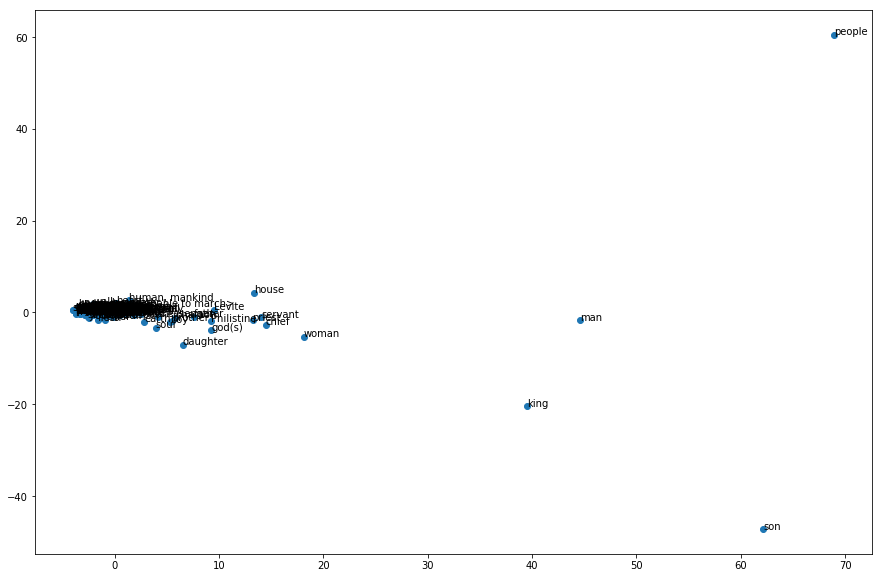

In [129]:
pca_pmi = pca.fit_transform(test_pmi.T.values)

# create a scatter plot of the projection
plt.figure(1, figsize=(15, 10))
plt.scatter(pca_pmi[:, 0], pca_pmi[:, 1])

cluster1 = [-5, 20, -10, 10]
cluster2 = [-0.8, 3, -1.25, 1.5]
[-6, 20, -3, 20]

#plt.axis([-1, 2, -3, 5])
#plt.axis([-6, 20, -5, 6])

# annotate 
words = [F.gloss.v(get_lex(l)) for l in test_pmi.columns]
for i, word in enumerate(words):
    plt.annotate(word, xy=(pca_pmi[i, 0], pca_pmi[i, 1]))

## Data Exploration

### Is there a correlation between Subject frames and Position on X-Axis of the Space?

In other words, are objects further along the x axis of the semantic space more "agentive", i.e. take the subject position more often?

In [130]:

def show_dependency(test_matrix, pca_vectors, boolean_req, invert=False, prop=False):
    
    '''
    Plot the frequency of a given relation, i.e. subject, object, 
    against the X axis of the semantic space. Fit a line through the points.
    '''
    
    # for testing proportional counts
    divisor = 1 if not prop else test_matrix.sum().values
    
    # get X and Y counts
    x = pd.Series(list(r[0] for r in pca_vectors)) # x-axes in the semantic space
    y = test_matrix[boolean_req].sum().values / divisor


    # prepare a trendline
    fit = np.polyfit(x, y, deg=1)
    p = np.poly1d(fit)

    # assemble DF for plotting
    x_rela = pd.DataFrame(x, columns=['X'])
    x_rela['rela'] = y
    x_rela['trendline'] = p(x_rela.loc[:, 'X'])

    #plot
    ax = x_rela.plot.scatter(x='X', y='rela', figsize=(10, 8))
    x_rela.set_index('X', inplace=True)
    x_rela.trendline.sort_index(ascending=True).plot(ax=ax)

    if invert:
        plt.gca().invert_xaxis()
        plt.gca().invert_yaxis()
    
    # annotate
    words = [F.gloss.v(get_lex(l)) for l in test_matrix.columns]
    for i, word in enumerate(words):
        plt.annotate(word, xy=(x[i], y[i]))

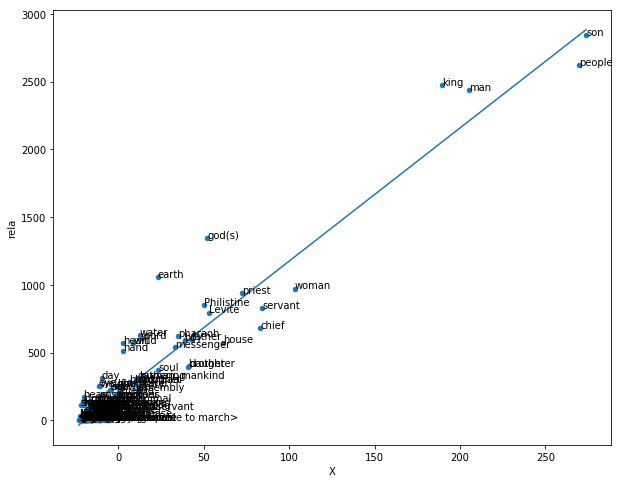

In [131]:
show_dependency(test_ll, pca_ll, test_ll.index.str.startswith('Subj'))

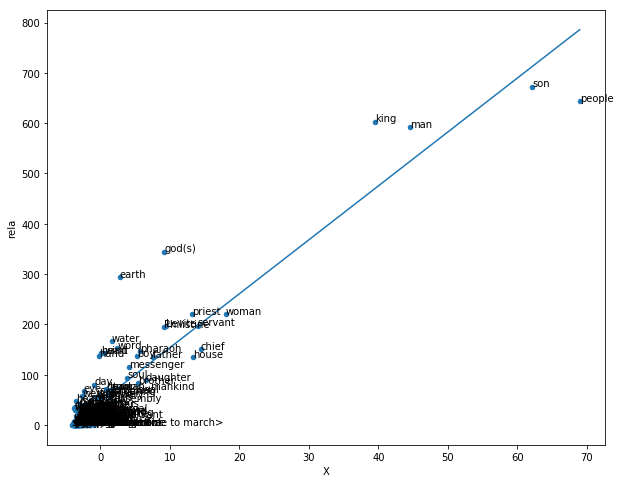

In [132]:
show_dependency(test_pmi, pca_pmi, test_pmi.index.str.startswith('Subj'))

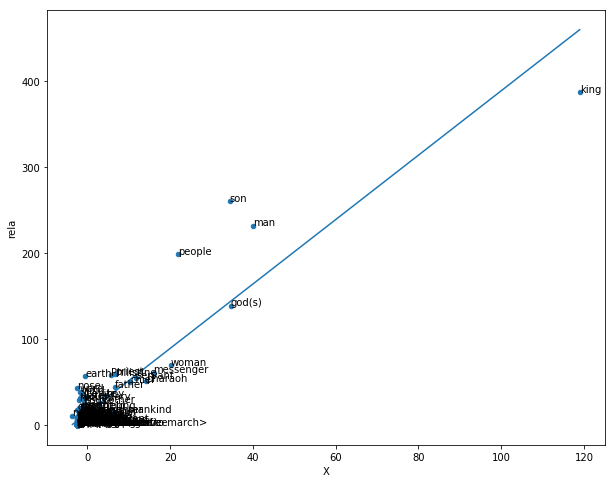

In [133]:
show_dependency(cooccurrences, pca_raw, cooccurrences.index.str.startswith('Subj'))

### X Plotted Against Number of Samples

Is number of samples a better predictor for distance along X axis?

In [134]:
def test_number(test_matrix, pca_vectors):
    
    # get X and Y counts
    x = pd.Series(list(r[0] for r in pca_vectors)) # x-axes in the semantic space
    y = test_matrix.sum().values 

    # prepare a trendline
    fit = np.polyfit(x, y, deg=1)
    p = np.poly1d(fit)

    # assemble DF for plotting
    x_rela = pd.DataFrame(x, columns=['X'])
    x_rela['# samples'] = y
    x_rela['trendline'] = p(x_rela.loc[:, 'X'])

    #plot
    ax = x_rela.plot.scatter(x='X', y='# samples', figsize=(10, 8))
    x_rela.set_index('X', inplace=True)
    x_rela.trendline.sort_index(ascending=True).plot(ax=ax)

    # annotate
    words = [F.gloss.v(get_lex(l)) for l in test_matrix.columns]
    for i, word in enumerate(words):
        plt.annotate(word, xy=(x[i], y[i]))

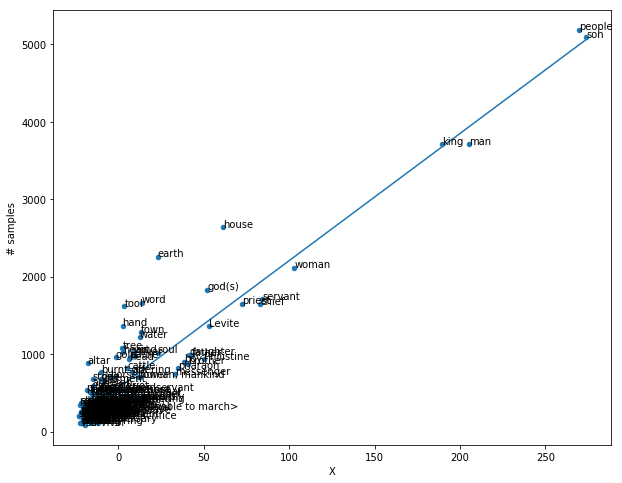

In [135]:
test_number(test_ll, pca_ll)

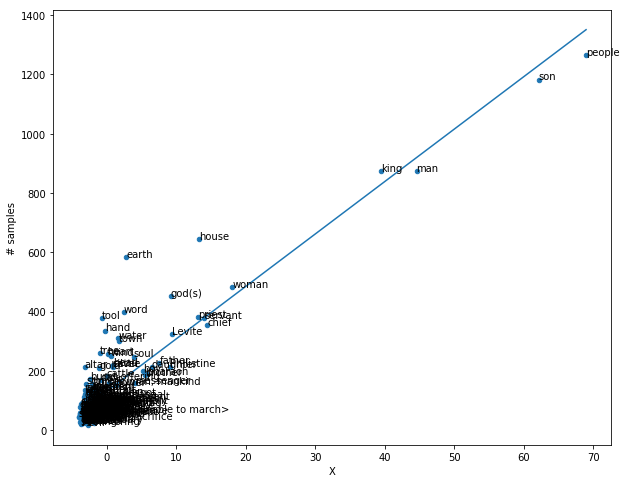

In [136]:
test_number(test_pmi, pca_pmi)

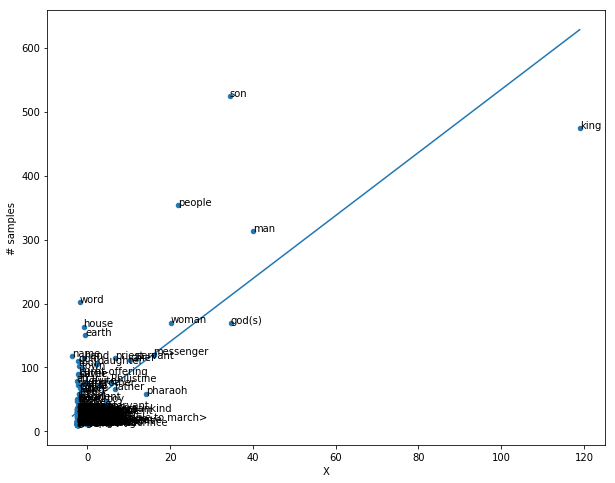

In [137]:
test_number(cooccurrences, pca_raw)

The number of samples could be a contributing factor to the distance on the X axis.

Agency could be slightly favorable to a larger value on the X axis of the semantic space. But it doesn't appear to be a strong association. In most cases, the four nuns MLK/, >M/, BN/, and >JC/ appear to be the most unlike the rest of the nouns.

### Against Proportional Counts

When "Subject" or "object" is counter proportionally, does the relationship still hold?

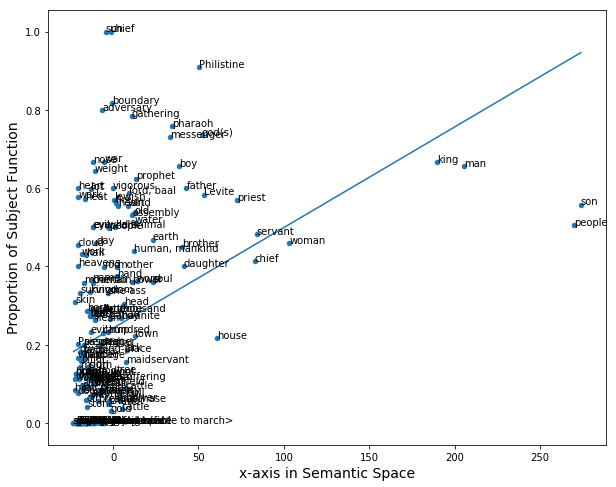

In [138]:
show_dependency(test_ll, pca_ll, test_ll.index.str.startswith('Subj'), prop=True)
plt.xlabel('x-axis in Semantic Space', fontsize=14)
plt.ylabel('Proportion of Subject Function', fontsize=14)
plt.savefig('images/test_agency.png')

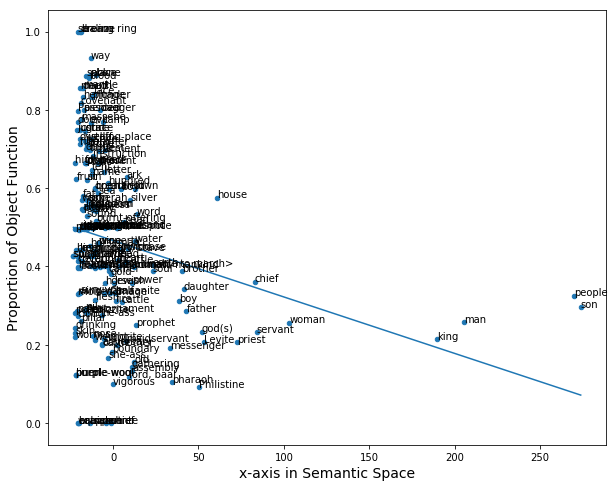

In [139]:
# and against objects...
show_dependency(test_ll, pca_ll, test_ll.index.str.startswith('Objc'), prop=True)
plt.xlabel('x-axis in Semantic Space', fontsize=14)
plt.ylabel('Proportion of Object Function', fontsize=14)
plt.savefig('images/test_object.png')

#### Experiment: Removing potential "outliers"

In [140]:
# experiment: Remove potential "outliers"

new_test_ll = test_ll.copy()
del new_test_ll['BN/']
del new_test_ll['<M/']
del new_test_ll['MLK/']
del new_test_ll['>JC/']
pca_nll = pca.fit_transform(new_test_ll.T.values)

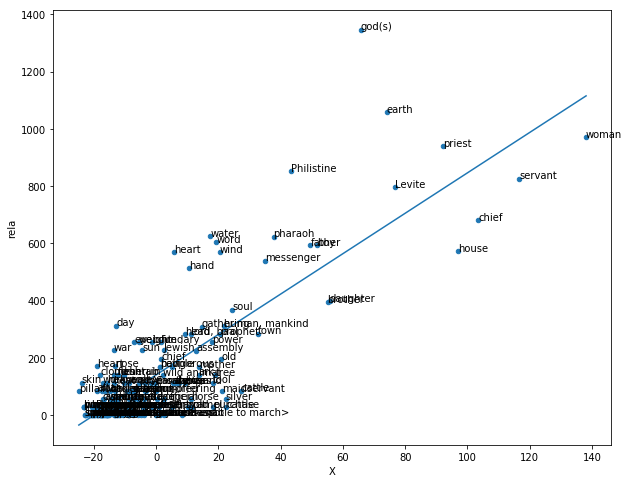

In [141]:
show_dependency(new_test_ll, pca_nll, new_test_ll.index.str.startswith('Subj'))

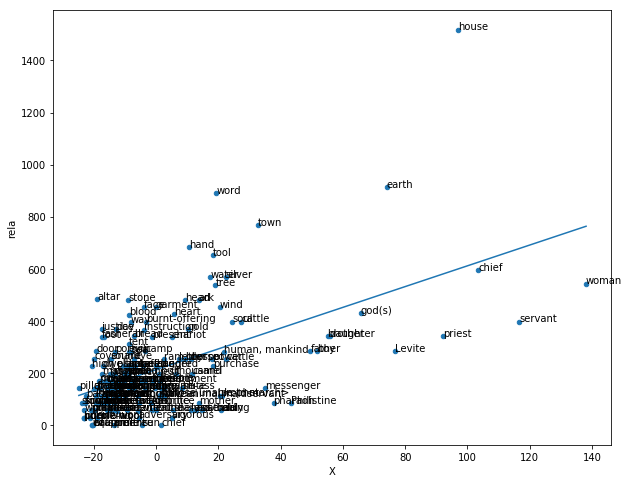

In [142]:
# against the objects...
show_dependency(new_test_ll, pca_nll, new_test_ll.index.str.startswith('Objc'))

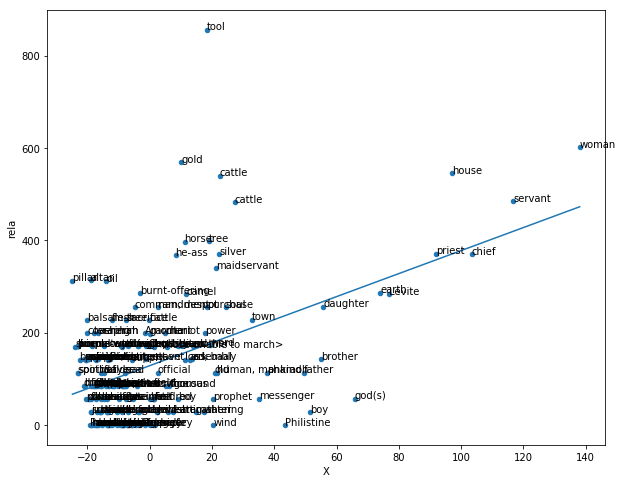

In [143]:
# against coordinates....

show_dependency(new_test_ll, pca_nll, new_test_ll.index.str.startswith('coor'))

### X Plotted aganst Object and Coordination (Raw Frequencies)

Now against the "object" relation with raw frequencies.

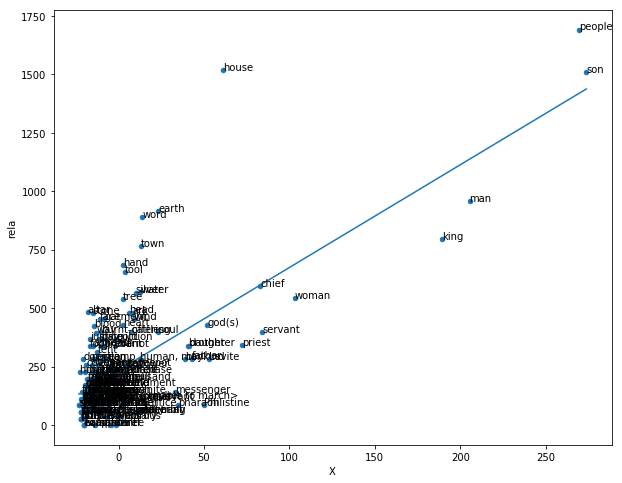

In [144]:
show_dependency(test_ll, pca_ll, test_ll.index.str.startswith('Objc'))

And against "coordinate" relation.

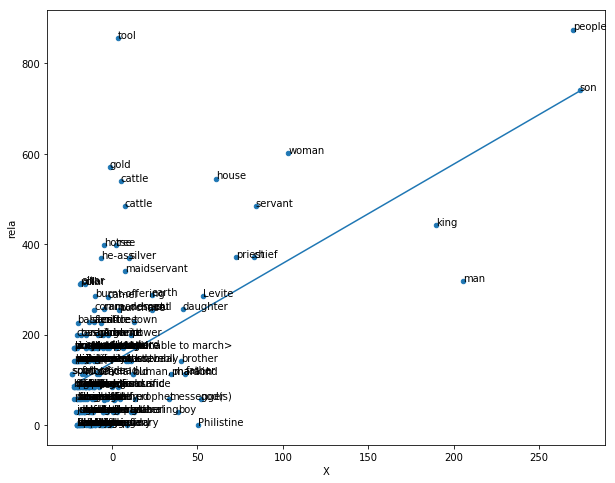

In [145]:
show_dependency(test_ll, pca_ll, test_ll.index.str.startswith('coor'))

## Similarity

Use cosine similarity to construct a similarity matrix.

Obtain A Similarity Matrix

In [146]:
row_col = [F.lex.v(get_lex(w)) + ' ' + '"' + F.gloss.v(get_lex(w)) + '"' for w in test_ll.columns]

ll_dists = pd.DataFrame(pairwise_distances(test_ll.T.values, metric='cosine'),
                        columns=row_col, 
                        index=row_col
                        )

ll_similar = ll_dists.apply(lambda x: 1-x) # 1-x to transform similarity to dissimilarity

Examine matches to most common nouns.

In [147]:
common = cooccurrences.sum().sort_values(ascending=False).head(50)

for i, noun in enumerate(common.index):
    
    if i+1 > 2: # restrict to 2 printouts
        break

    gloss = F.gloss.v(get_lex(noun))
    key = noun + ' ' + '"' + gloss + '"'
    print(key)
    print(round(ll_similar[key].sort_values(ascending=False)[1:10], 3))
    round(ll_similar[key].sort_values(ascending=False)[1:], 3).to_csv(f'data/{gloss}_similarities.csv')
    print()

BN/ "son"
>JC/ "man"             0.403
<M/ "people"           0.392
MLK/ "king"            0.372
BT/ "daughter"         0.346
>CH/ "woman"           0.335
PLCTJ/ "Philistine"    0.304
<BD/ "servant"         0.303
FR/ "chief"            0.298
KHN/ "priest"          0.269
Name: BN/ "son", dtype: float64

MLK/ "king"
BN/ "son"              0.372
FR/ "chief"            0.372
>JC/ "man"             0.336
<M/ "people"           0.332
PR<H/ "pharaoh"        0.329
>B/ "father"           0.299
>CH/ "woman"           0.277
KHN/ "priest"          0.267
PLCTJ/ "Philistine"    0.261
Name: MLK/ "king", dtype: float64



In [148]:
round(ll_similar['MJM/ "water"'].sort_values(ascending=False)[1:10], 3) # just a random term to test, "water"

XKMH/ "wisdom"        0.252
JM/ "sea"             0.221
JD/ "hand"            0.218
JJN/ "wine"           0.210
XJH/ "wild animal"    0.190
KSP/ "silver"         0.179
R<H/ "evil"           0.169
CMC/ "sun"            0.161
<JR/ "town"           0.158
Name: MJM/ "water", dtype: float64

In [149]:
def show_sim(testw, test):    
    
    '''
    Return a comparison of similar words for a given test word.
    !No longer needed — see pairwise_distances!
    '''
    
    test_sims = []
    vectA = test[testw]

    for word in test.columns:

        if word  == testw:
            continue

        vectB = test[word]

        cosine = sum(vectA * vectB) / (math.sqrt(sum(vectA*vectA)) * math.sqrt(sum(vectB*vectB)))

        test_sims.append((cosine, word))

    results = []
        
    for score, word in sorted(test_sims, reverse=True)[:25]:

        lex = [lex for lex in F.otype.s('lex') if F.lex.v(lex) == word][0]

        results.append([score, word, F.gloss.v(lex), F.freq_lex.v(lex)])
        
    return(results)

## Clustering

What clusters of nouns are in the data?

In this case, I want general sets of similar words rather than relations between them (as in a hierarchical method). The goal is to create hierarchy later on, when other information such as lexico-syntactic patterns can be used to extract hyper/hyponym relations.

Thus, rather than using hierarchical clustering, I would like to use a partitioning method. The [k-medoid method](https://en.wikipedia.org/wiki/K-medoids) is a good approach which is less sensitive to outliers.

Another benefit to using a partitioning method is that I can obtain a predetermined number ("`K`") of clusters. At the same time, how to decide on what the best number of clusters to ask the algorithm for?

A [silhouette plot](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) can be used for determining the ideal `K`. I do that here first to find `K`.

In [184]:
def plot_silhouettes(data_vectors, range_n_clusters, scatter=False):
    
    '''    
    Plot silhouette plots based on a supplied range of K using a supplied method.
    Can also plot an optional scatter plot if PCA transformed vectors are supplied.
    Code modified from http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
    '''
    
    pairwise_dists = pairwise_distances(data_vectors, metric='cosine')
    
    for n_clusters in range_n_clusters:
        
        # use method to make the clusters
        medoids, clusters = kmedoids.kMedoids(pairwise_dists, n_clusters)
    
        # make cluster labels with index corresponding to target word cluster
        cluster_labels = sorted((i, group) for group in clusters # sort groups by index
                                    for i in clusters[group])
        cluster_labels = np.array(list(group[1] for group in cluster_labels)) # put the groups in indexed order in an array
        
        # Create plots
        if not scatter:
            fig, ax = plt.subplots(1, 1)
            fig.set_size_inches(10, 8)
        else:
            fig, (ax, ax2) = plt.subplots(1,2)
            fig.set_size_inches(18, 7)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(pairwise_dists, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(pairwise_dists, cluster_labels)
                
        # Set x-axis limits
        # The silhouette coefficient can range from -1, 1
        # I set the lower limit a -0.2 since the min with one method is -0.13
        ax.set_xlim([-0.2, 0.06])
        
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax.set_ylim([0, len(pairwise_dists) + (n_clusters + 1) * 10])
        
        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.ocean(float(i) / n_clusters)
            ax.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor='black', alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax.set_title("The silhouette plot for the various clusters.")
        ax.set_xlabel("The silhouette coefficient values")
        ax.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax.set_yticks([])  # Clear the yaxis labels / ticks
        ax.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
        
        # plot scatter if PCA data is given
        if scatter:
            colors = cm.ocean(cluster_labels.astype(float) / n_clusters)
            ax2.scatter(data_vectors[:, 0], data_vectors[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                        c=colors, edgecolor='k')

            # Labeling the clusters
            centers = data_vectors[medoids]
            # Draw white circles at cluster centers
            ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                        c="white", alpha=1, s=200, edgecolor='k')

            for i, c in enumerate(centers):
                ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                            s=50, edgecolor='k')

            ax2.set_title("The visualization of the clustered data.")
            ax2.set_xlabel("Feature space for the 1st feature")
            ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')
        

        plt.show()

In [185]:
# distance matrices
ll_dists = pairwise_distances(test_ll.T.values, metric='cosine')
pmi_dists = pairwise_distances(test_pmi.T.values, metric='cosine')
raw_dists = pairwise_distances(cooccurrences.T.values, metric='cosine')

### K-Medoids Method

#### Log-Likelihood, non-pca 

For n_clusters = 2 The average silhouette_score is : 0.03469372904076026


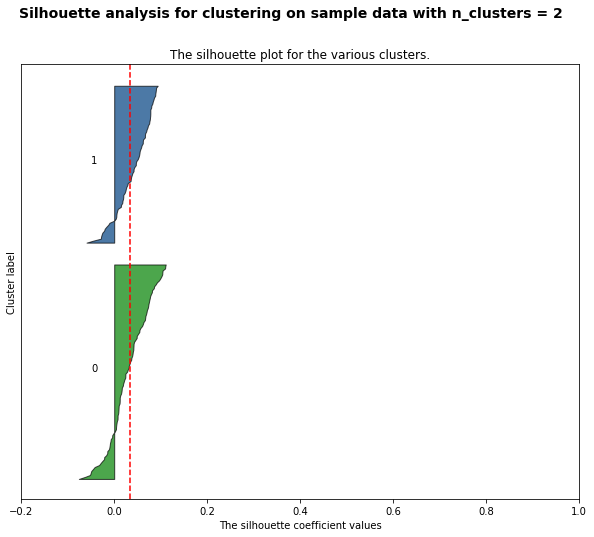

For n_clusters = 3 The average silhouette_score is : 0.03827887617617667


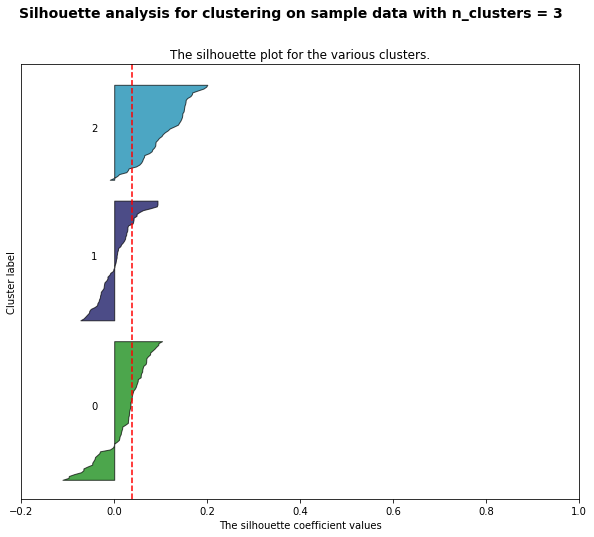

For n_clusters = 4 The average silhouette_score is : 0.040834581610293824


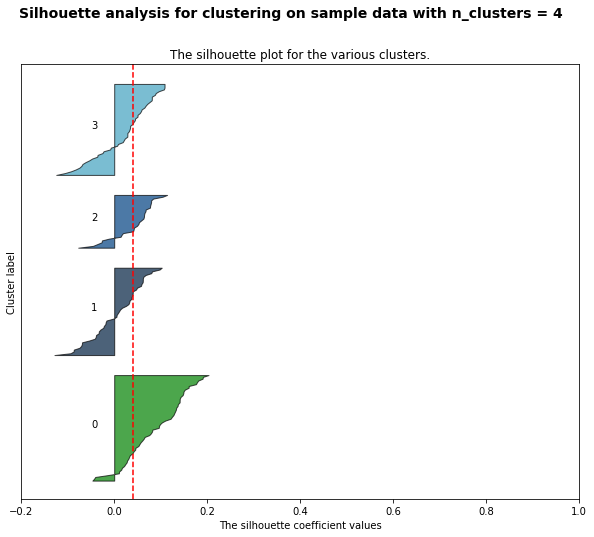

For n_clusters = 5 The average silhouette_score is : 0.06117597677199181


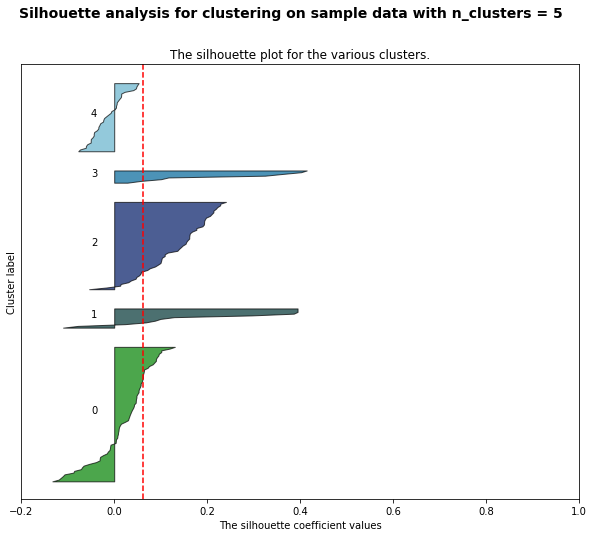

For n_clusters = 6 The average silhouette_score is : 0.023609924505138883


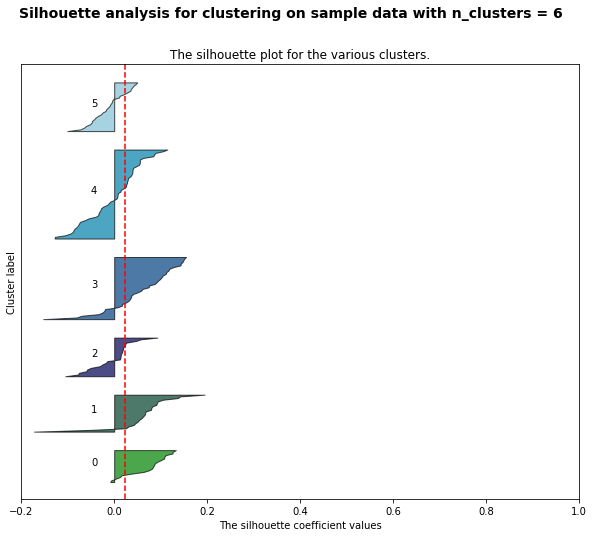

For n_clusters = 7 The average silhouette_score is : 0.015424171924815839


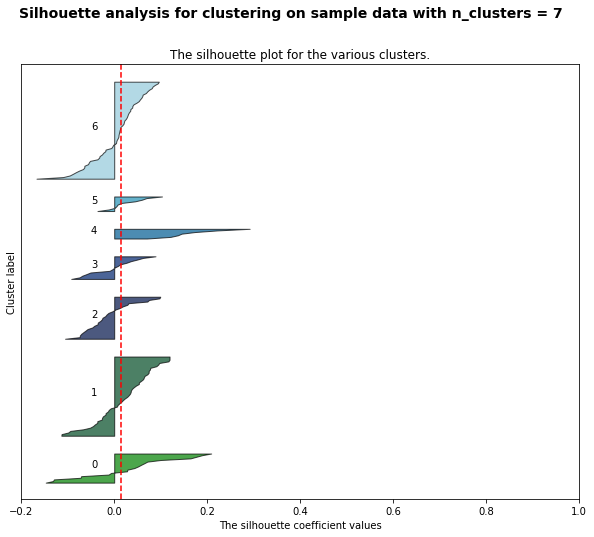

For n_clusters = 8 The average silhouette_score is : 0.0025053387178303127


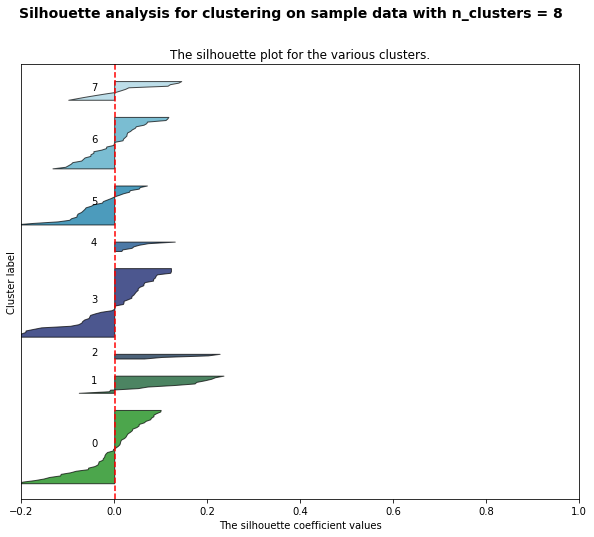

For n_clusters = 10 The average silhouette_score is : 0.036902855888884145


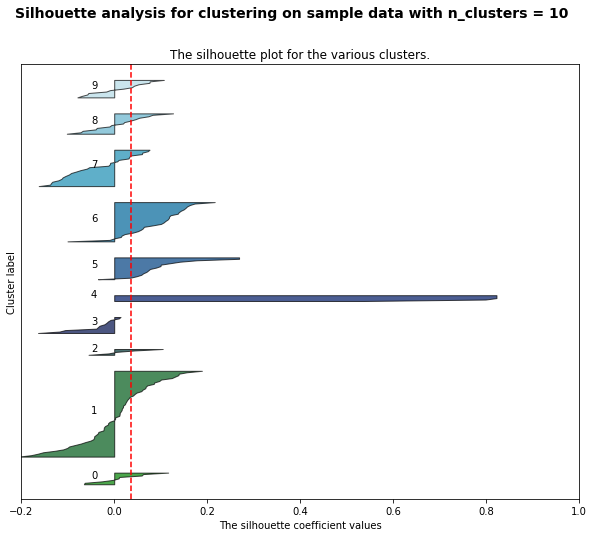

In [187]:
plot_silhouettes(test_ll.T.values, [2, 3, 4, 5, 6, 7, 8, 10])

#### Log-likelihood, PCA

For n_clusters = 2 The average silhouette_score is : 0.5170469628856839


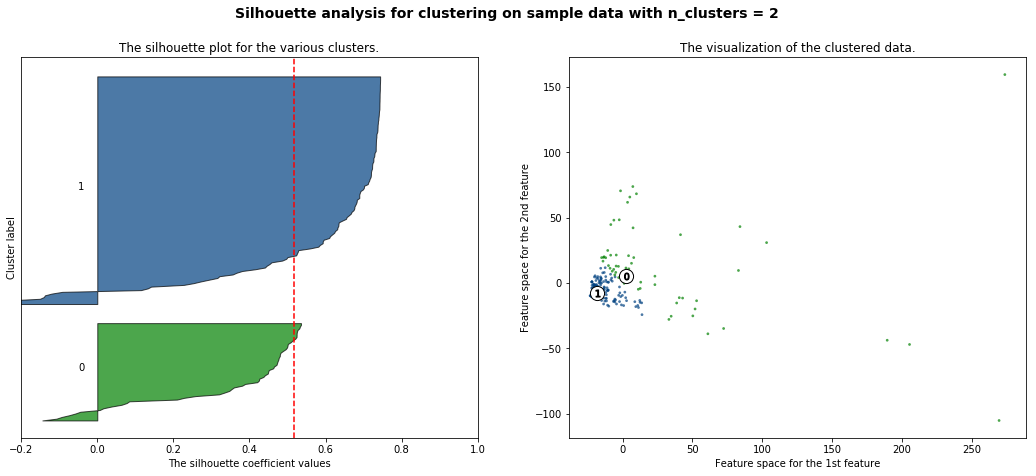

For n_clusters = 3 The average silhouette_score is : 0.6020070537572886


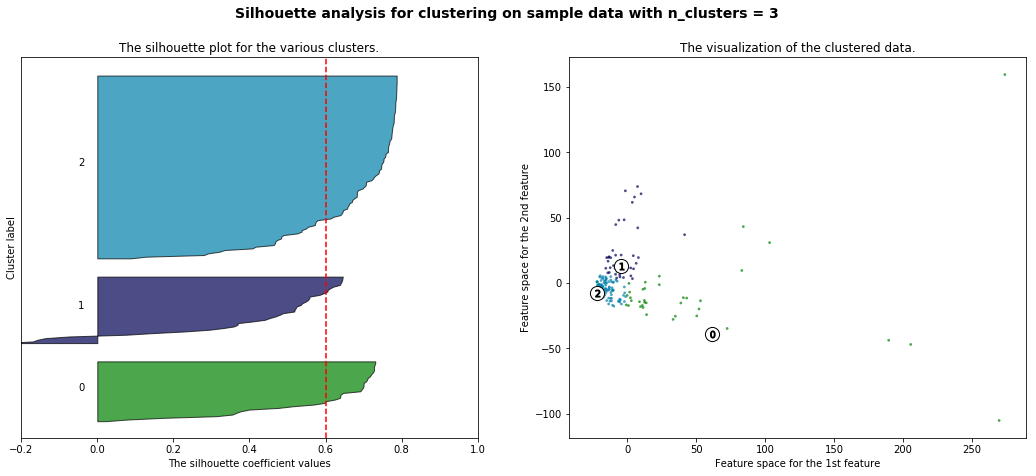

For n_clusters = 4 The average silhouette_score is : 0.4831898043115828


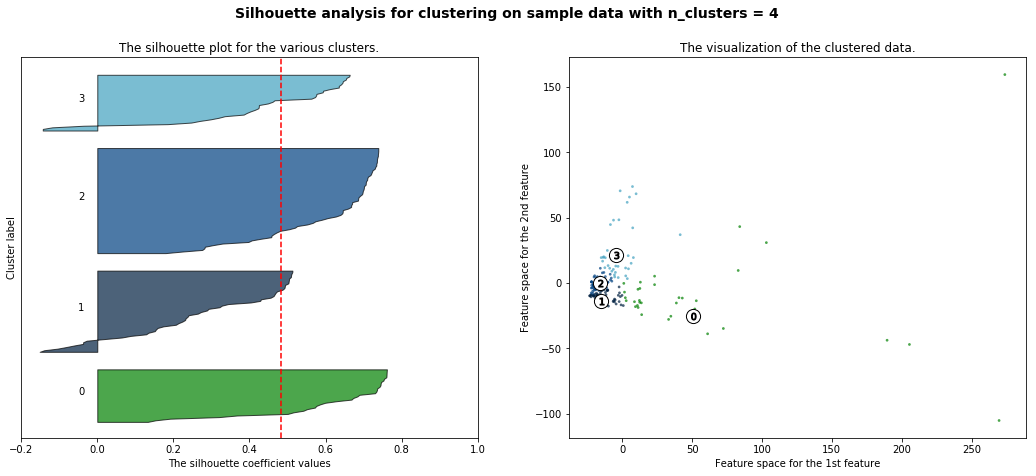

For n_clusters = 5 The average silhouette_score is : 0.5248177884877621


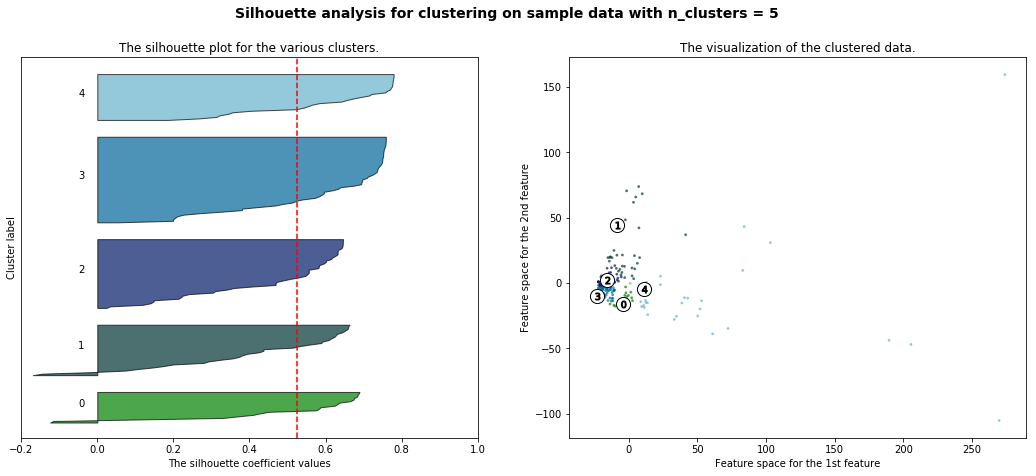

For n_clusters = 6 The average silhouette_score is : 0.546570783303977


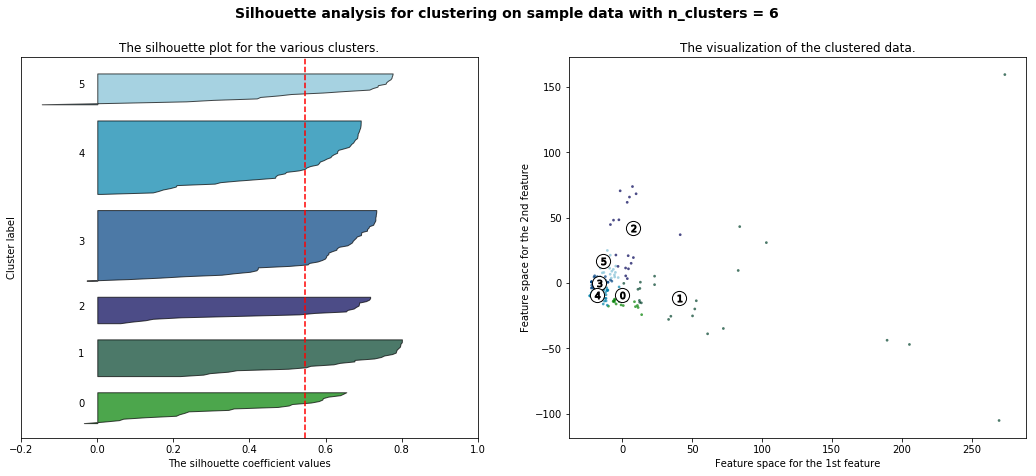

For n_clusters = 7 The average silhouette_score is : 0.4892058094204285


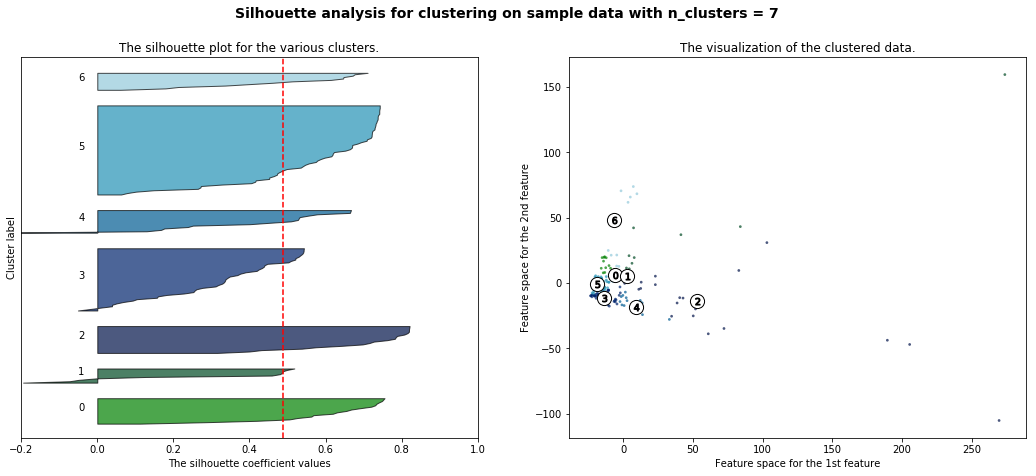

For n_clusters = 8 The average silhouette_score is : 0.5177167136296291


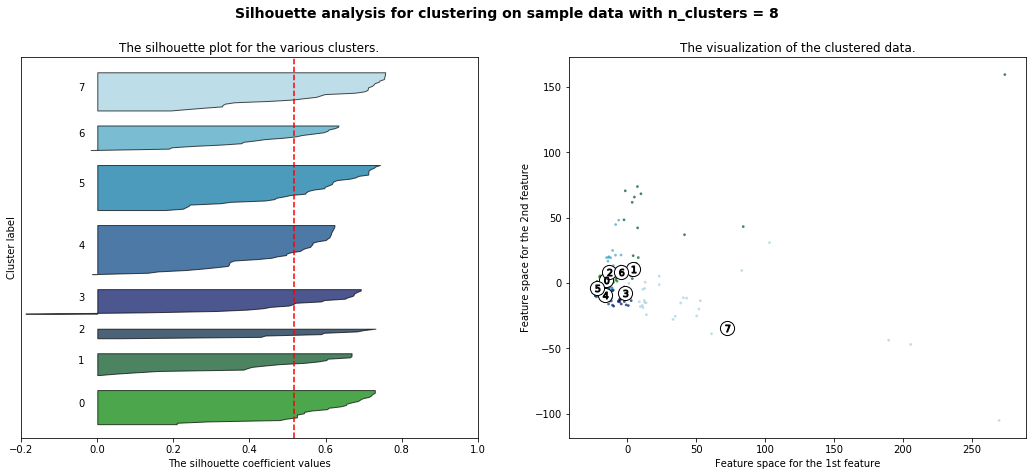

For n_clusters = 10 The average silhouette_score is : 0.5400741346893201


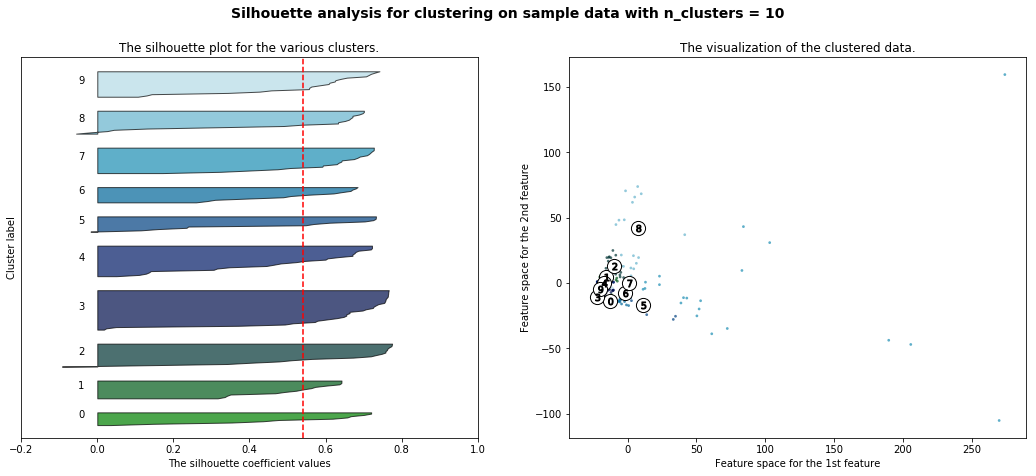

In [188]:
plot_silhouettes(pca_ll, [2, 3, 4, 5, 6, 7, 8, 10], scatter=True)

### Basic Medoid Tests

In [82]:
# LL Cluster
ll_medoids, ll_clust = kmedoids.kMedoids(ll_dists, 2) # experiemnting with K=2
test_ll.columns[ll_medoids]

Index(['R</', 'XRB/'], dtype='object')

In [83]:
# make cluster labels with index corresponding to target word cluster
ll_clust_labels = sorted((i, group) for group in ll_clust # sort groups by index
                            for i in ll_clust[group])
ll_clust_labels = np.array(list(group[1] for group in ll_clust_labels)) # pull the groups in indexed order in an array

In [56]:
plot_silhouettes(ll_dists, ll_clust_labels, )

-0.134

In [45]:
for group, ids in ll_clust.items():
    
    print(group)
    
    for i in ids:
        w = get_lex(test_ll.columns[i])
        print(F.gloss.v(w), end=' | ')
    print()
    print()

0
servant | gathering | eye | people | cloud | dust | bone | father | woman | tent | man | ram, despot | god(s) | mother | Amorite | nose | she-ass | brother | lord, baal | balsam-tree | house | son | covenant | daughter | gate | rod | sun | open field | wrapper | chief | survivor | adversary | boundary | vigorous | idols | people | lot | Jewish | day | priest | wing | palm | heart | Levite | messenger | king | war | camp | boy | prophet | equipment | chief | soul | Philistine | pharaoh | horseman | assembly | chariot | palm-ornament | <those unable to march> | power | wisdom | pierced | dream | wall | half | old | 

1
work | reminder | town | burnt-offering | pillar | skin | tree | stone | fire | asherah | human, mankind | pillar | porch | thousand | ephod | purple-wool | ark | earth | spirit of dead | sign | supply | linen, part, stave | flesh | garment | cattle | high place | cattle | hail | rest | linen | plunder | final offer | table | name | heavens | oil | maidservant | idol | w